## Packages

In [137]:
from gensim.models import Word2Vec
import numpy as np
import pandas as pd
from keras.callbacks import EarlyStopping
import seaborn as sns
import keras_tuner as kt
from tensorflow.keras.optimizers import SGD, RMSprop, Adam

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
import matplotlib.pyplot as plt
from keras.preprocessing.text import tokenizer_from_json
import os, sys
from keras.losses import BinaryCrossentropy

import keras.backend as K

In [138]:
print(sys.executable)
print(os.getcwd())

C:\Users\Guilherme\.conda\envs\nlp2\python.exe
C:\Users\Guilherme\Documents\Programming\Python\DataScience\TCC_stock_price\pipeline\supervised_deep_models


## Dependencies

In [139]:
with open('../../assets/deep_assets/tokenizer.json', 'r', encoding='utf-8') as f:
    tokenizer_json = f.read()
    tokenizer = tokenizer_from_json(tokenizer_json)
    word_index = tokenizer.word_index

len(word_index)

4624

In [140]:
model_we = Word2Vec.load('../../assets/deep_assets/word2vec.model')

print(model_we.wv.most_similar('petr4'))

# List of nparrays of size 300
embeddings_dict = {}
for word in model_we.wv.index_to_key:
    embeddings_dict[word] = model_we.wv[word]

embeddings_on_this_context = np.zeros((len(word_index), 300))
for word, i in word_index.items():
    embeddings_vector = embeddings_dict.get(word)
    if embeddings_vector is not None:
        embeddings_on_this_context[i - 1] = embeddings_vector


[('mercado', 0.8972763419151306), ('elet3', 0.8876447081565857), ('financeiro', 0.8797796964645386), ('eletrobras', 0.8726834058761597), ('atencao', 0.8672264814376831), ('chamam', 0.8558464050292969), ('agitam', 0.8534992933273315), ('oibr3', 0.8169822692871094), ('mexem', 0.8063585162162781), ('irbr3', 0.8050428628921509)]


In [141]:
train_padded = pd.read_csv('../../assets/data/splits/train/padded.csv')
val_padded = pd.read_csv('../../assets/data/splits/val/padded.csv')

## Functions

In [142]:
def index2word(word_index):
    index_word = {}
    for key in word_index:
        index_word[word_index[key]] = key
    return index_word


def seq2text(seq, index_word):
    text = []
    for index in seq:
        text.append(index_word[index])
    return text


def show_confusion_matrix(cm):
    print("Confusion Matrix")
    plt.figure(figsize=(10, 7))

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.title('Confusion Matrix')
    plt.show()

## RNN Models

Tuning Architecture Hyperparams using RandomSearch and Early Stopping

### Preparing RNN inputs

In [143]:
X_train = train_padded.to_numpy()[:, :-1]
X_val = val_padded.to_numpy()[:, :-1]
y_train = train_padded.to_numpy()[:, -1]
y_val = val_padded.to_numpy()[:, -1]

### LSTM

#### Tuning

In [144]:
def build_model(hp):
    model = Sequential([
        Embedding(input_dim=len(word_index), output_dim=25, input_length=X_train.shape[1]),
        LSTM(hp.Choice('units_lstm_1', [16, 32, 64]), return_sequences=True),
        Dropout(hp.Float('rate_dp_1', 0, 0.3, step=0.1)),
        LSTM(hp.Choice('units_lstm_2', [16, 32, 64])),
        Dense(hp.Choice('units_dense', [16, 32, 64]), hp.Choice('activation', ['tanh'])),
        Dropout(hp.Float('rate_dp_2', 0, 0.3, step=0.1)),
        Dense(3, activation='softmax')
    ])
    loss = 'sparse_categorical_crossentropy'
    # optimizer = RMSprop())
    metrics = ['accuracy']
    # metrics = ['accuracy', Precision(), Recall()]

    optimizer = Adam(0.0001)

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [145]:
# amanha testar dropout 0.0, 0.1, 0.2
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='../../assets/deep_assets',
    overwrite=True,
    project_name='lstm_tuning')

tuner.search_space_summary()

Search space summary
Default search space size: 6
units_lstm_1 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
rate_dp_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': 'linear'}
units_lstm_2 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
units_dense (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
activation (Choice)
{'default': 'tanh', 'conditions': [], 'values': ['tanh'], 'ordered': False}
rate_dp_2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': 'linear'}


In [146]:
tuner.search(X_train, y_train, epochs=4000, validation_data=(X_val, y_val), callbacks=[es], batch_size=32, verbose=2)
tuner.results_summary()

Trial 10 Complete [00h 00m 22s]
val_accuracy: 0.5011286735534668

Best val_accuracy So Far: 0.5101580023765564
Total elapsed time: 00h 03m 46s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Results summary
Results in ../../assets/deep_assets\lstm_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 02 summary
Hyperparameters:
units_lstm_1: 32
rate_dp_1: 0.0
units_lstm_2: 32
units_dense: 32
activation: tanh
rate_dp_2: 0.1
Score: 0.5101580023765564

Trial 05 summary
Hyperparameters:
units_lstm_1: 32
rate_dp_1: 0.1
units_lstm_2: 32
units_dense: 64
activation: tanh
rate_dp_2: 0.2
Score: 0.5079006552696228

Trial 04 summary
Hyperparameters:
units_lstm_1: 32
rate_dp_1: 0.1
units_lstm_2: 16
units_dense: 16
activation: tanh
rate_dp_2: 0.0
Score: 0.505643367767334

Trial 00 summary
Hyperparameters:
units_lstm_1: 32
rate_dp_1: 0.1
units_lstm_2: 32
units_dense: 32
activation: tanh
rate_dp_2: 0.1
Score: 0.5033860206604004

Trial 06 summary
Hyperparameters:
units_lstm_1: 16
rate_dp_1: 0.2
units_lstm_2: 32
units_dense: 32
activation: tanh
rate_dp_2: 0.0
Score: 0.5011286735534668

Trial 08 summary
Hyperparameters:
units_lstm_1: 16
rate_dp_1: 0.2
units_lst

In [147]:
best_model_lstm_params = tuner.get_best_hyperparameters()[0].values

#### Declaring Best Model and Plotting Accuracy and Loss

In [148]:
best_model_lstm = Sequential([
    Embedding(input_dim=len(word_index), output_dim=25, input_length=X_train.shape[1]),
    LSTM(best_model_lstm_params['units_lstm_1'], return_sequences=True),
    Dropout(best_model_lstm_params['rate_dp_1']),
    # Bidirectional(LSTM(hp.Choice('units',[32,64]))),
    LSTM(best_model_lstm_params['units_lstm_2']),
    Dense(best_model_lstm_params['units_dense'], activation=best_model_lstm_params['activation']),
    # Dropout(0.73),
    Dense(3, activation='softmax')
])

loss = 'sparse_categorical_crossentropy'
#
optimizer = Adam(0.0001)

metrics = ['accuracy']

best_model_lstm.compile(loss=loss, optimizer=optimizer, metrics=metrics)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

best_model_lstm.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 8, 25)             115600    
                                                                 
 lstm_2 (LSTM)               (None, 8, 32)             7424      
                                                                 
 dropout_2 (Dropout)         (None, 8, 32)             0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 3)                 99        
                                                                 
Total params: 132,499
Trainable params: 132,499
Non-tr

In [149]:
history = best_model_lstm.fit(X_train, y_train, epochs=4000, batch_size=32, validation_data=(X_val, y_val), verbose=2,
                              callbacks=[es])

Epoch 1/4000
111/111 - 6s - loss: 1.0647 - accuracy: 0.4670 - val_loss: 1.0110 - val_accuracy: 0.4989 - 6s/epoch - 51ms/step
Epoch 2/4000
111/111 - 1s - loss: 0.9647 - accuracy: 0.4735 - val_loss: 0.9514 - val_accuracy: 0.4989 - 856ms/epoch - 8ms/step
Epoch 3/4000
111/111 - 1s - loss: 0.9430 - accuracy: 0.4735 - val_loss: 0.9525 - val_accuracy: 0.4989 - 832ms/epoch - 7ms/step
Epoch 4/4000
111/111 - 1s - loss: 0.9376 - accuracy: 0.4735 - val_loss: 0.9543 - val_accuracy: 0.4989 - 816ms/epoch - 7ms/step
Epoch 5/4000
111/111 - 1s - loss: 0.9306 - accuracy: 0.4735 - val_loss: 0.9530 - val_accuracy: 0.4989 - 850ms/epoch - 8ms/step
Epoch 6/4000
111/111 - 1s - loss: 0.9185 - accuracy: 0.4735 - val_loss: 0.9621 - val_accuracy: 0.4989 - 836ms/epoch - 8ms/step
Epoch 7/4000
111/111 - 1s - loss: 0.8998 - accuracy: 0.4740 - val_loss: 0.9656 - val_accuracy: 0.4966 - 959ms/epoch - 9ms/step
Epoch 8/4000
111/111 - 1s - loss: 0.8697 - accuracy: 0.4802 - val_loss: 0.9921 - val_accuracy: 0.4966 - 937ms/epo

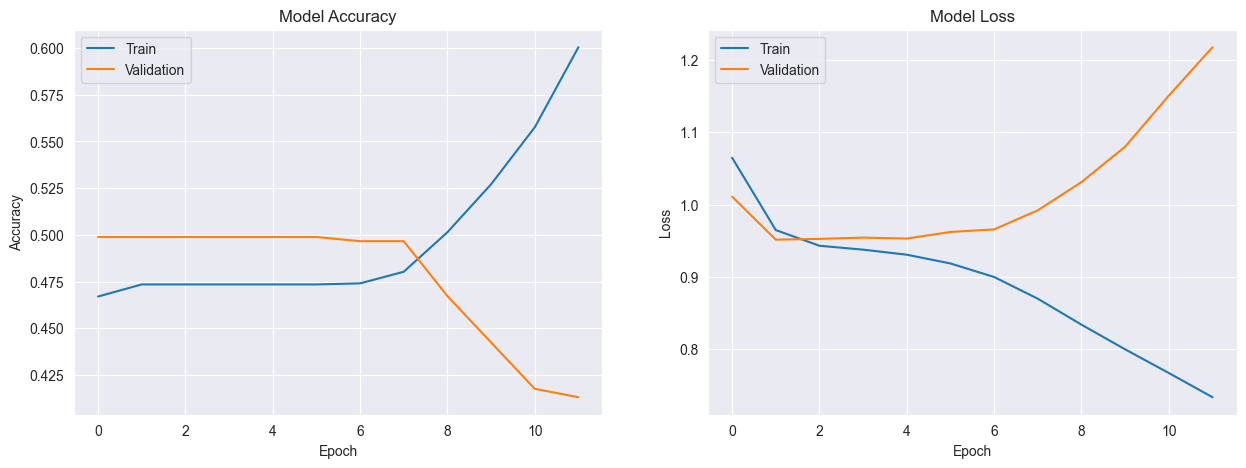

In [150]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### BiLSTM

#### Tuning

In [151]:
def build_model(hp):
    model = Sequential([
        Embedding(input_dim=len(word_index), output_dim=25, input_length=X_train.shape[1]),
        Bidirectional(LSTM(hp.Choice('units_bilstm_1', [16, 32, 64]), return_sequences=True)),
        Dropout(hp.Float('rate_dp_1', 0, 0.3, step=0.1)),
        Bidirectional(LSTM(hp.Choice('units_bilstm_2', [16, 32, 64]))),
        Dense(hp.Choice('units_dense', [16, 32, 64]), hp.Choice('activation', ['tanh'])),
        Dropout(hp.Float('rate_dp_2', 0, 0.3, step=0.1)),
        Dense(3, activation='softmax')
    ])
    loss = 'sparse_categorical_crossentropy'
    # optimizer = Adam(0.0001))
    metrics = ['accuracy']

    optimizer = Adam(0.0001)

    # metrics = ['accuracy', Precision(), Recall()]

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [152]:
# amanha testar dropout 0.0, 0.1, 0.2
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='../../assets/deep_assets',
    overwrite=True,
    project_name='bilstm_tuning')

tuner.search_space_summary()

Search space summary
Default search space size: 6
units_bilstm_1 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
rate_dp_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': 'linear'}
units_bilstm_2 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
units_dense (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
activation (Choice)
{'default': 'tanh', 'conditions': [], 'values': ['tanh'], 'ordered': False}
rate_dp_2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': 'linear'}


In [153]:
tuner.search(X_train, y_train, epochs=4000, validation_data=(X_val, y_val), callbacks=[es], batch_size=32, verbose=2)
tuner.results_summary()


Trial 10 Complete [00h 00m 32s]
val_accuracy: 0.4988713264465332

Best val_accuracy So Far: 0.5079006552696228
Total elapsed time: 00h 04m 57s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Results summary
Results in ../../assets/deep_assets\bilstm_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 06 summary
Hyperparameters:
units_bilstm_1: 16
rate_dp_1: 0.0
units_bilstm_2: 16
units_dense: 16
activation: tanh
rate_dp_2: 0.1
Score: 0.5079006552696228

Trial 05 summary
Hyperparameters:
units_bilstm_1: 32
rate_dp_1: 0.2
units_bilstm_2: 64
units_dense: 32
activation: tanh
rate_dp_2: 0.2
Score: 0.5033860206604004

Trial 07 summary
Hyperparameters:
units_bilstm_1: 64
rate_dp_1: 0.0
units_bilstm_2: 32
units_dense: 16
activation: tanh
rate_dp_2: 0.1
Score: 0.5033860206604004

Trial 08 summary
Hyperparameters:
units_bilstm_1: 32
rate_dp_1: 0.2
units_bilstm_2: 16
units_dense: 64
activation: tanh
rate_dp_2: 0.2
Score: 0.5033860206604004

Trial 00 summary
Hyperparameters:
units_bilstm_1: 64
rate_dp_1: 0.2
units_bilstm_2: 64
units_dense: 32
activation: tanh
rate_dp_2: 0.1
Score: 0.5011286735534668

Trial 01 summary
Hyperparameters:
units_bilstm_1: 64

In [154]:
best_model_bilstm_params = tuner.get_best_hyperparameters()[0].values

#### Declaring Best Model and Plotting Accuracy and Loss

In [155]:
# trainable=False,
# weights=[embeddings_on_this_context]),
best_model_bilstm = Sequential([
    Embedding(input_dim=len(word_index), output_dim=25, input_length=X_train.shape[1]),
    Bidirectional(LSTM(best_model_bilstm_params['units_bilstm_1'], return_sequences=True)),
    Dropout(best_model_bilstm_params['rate_dp_1']),
    # Bidirectional(LSTM(hp.Choice('units',[32,64]))),
    Bidirectional(LSTM(best_model_bilstm_params['units_bilstm_2'])),
    Dense(best_model_bilstm_params['units_dense'], activation=best_model_bilstm_params['activation']),
    # Dropout(0.73),
    Dense(3, activation='softmax')
])

loss = 'sparse_categorical_crossentropy'

metrics = ['accuracy']

optimizer = Adam(0.0001)

best_model_bilstm.compile(loss=loss, optimizer=optimizer, metrics=metrics)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

best_model_bilstm.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 8, 25)             115600    
                                                                 
 bidirectional_2 (Bidirectio  (None, 8, 32)            5376      
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 8, 32)             0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 3)                

In [156]:
history = best_model_bilstm.fit(X_train, y_train, epochs=4000, batch_size=32, validation_data=(X_val, y_val), verbose=2,
                                callbacks=[es])

Epoch 1/4000
111/111 - 9s - loss: 1.0706 - accuracy: 0.4690 - val_loss: 1.0329 - val_accuracy: 0.4989 - 9s/epoch - 83ms/step
Epoch 2/4000
111/111 - 1s - loss: 0.9883 - accuracy: 0.4735 - val_loss: 0.9544 - val_accuracy: 0.4989 - 915ms/epoch - 8ms/step
Epoch 3/4000
111/111 - 1s - loss: 0.9457 - accuracy: 0.4735 - val_loss: 0.9493 - val_accuracy: 0.4989 - 898ms/epoch - 8ms/step
Epoch 4/4000
111/111 - 1s - loss: 0.9401 - accuracy: 0.4735 - val_loss: 0.9490 - val_accuracy: 0.4989 - 930ms/epoch - 8ms/step
Epoch 5/4000
111/111 - 1s - loss: 0.9351 - accuracy: 0.4735 - val_loss: 0.9482 - val_accuracy: 0.4989 - 911ms/epoch - 8ms/step
Epoch 6/4000
111/111 - 1s - loss: 0.9281 - accuracy: 0.4735 - val_loss: 0.9472 - val_accuracy: 0.4989 - 908ms/epoch - 8ms/step
Epoch 7/4000
111/111 - 1s - loss: 0.9181 - accuracy: 0.4735 - val_loss: 0.9453 - val_accuracy: 0.4989 - 900ms/epoch - 8ms/step
Epoch 8/4000
111/111 - 1s - loss: 0.9024 - accuracy: 0.4774 - val_loss: 0.9433 - val_accuracy: 0.4989 - 915ms/epo

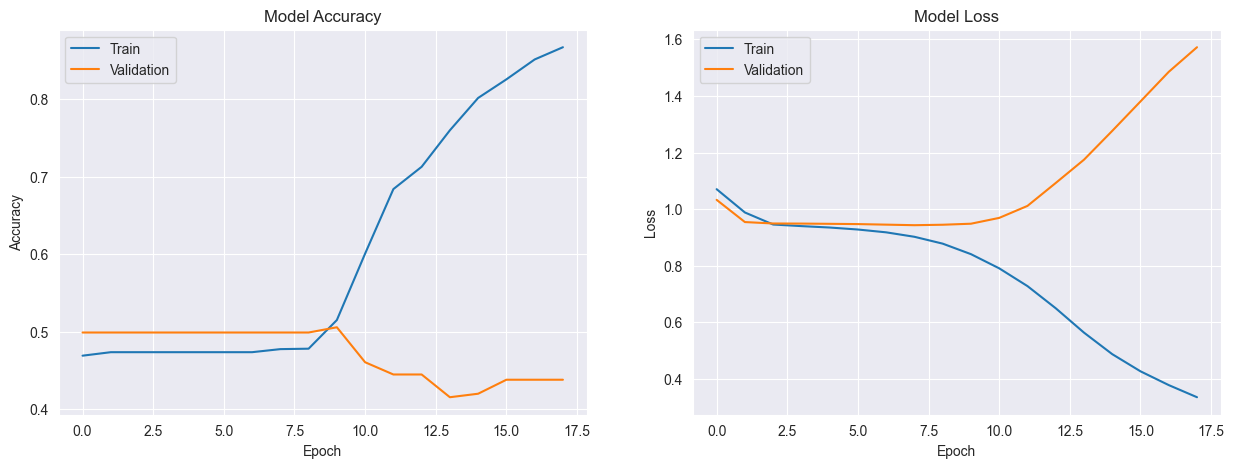

In [157]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Exporting model

In [158]:
best_model_lstm.save('../../assets/deep_assets/lstm_model')
best_model_bilstm.save('../../assets/deep_assets/bilstm_model')

INFO:tensorflow:Assets written to: ../../assets/deep_assets/lstm_model\assets


INFO:tensorflow:Assets written to: ../../assets/deep_assets/lstm_model\assets


INFO:tensorflow:Assets written to: ../../assets/deep_assets/bilstm_model\assets


INFO:tensorflow:Assets written to: ../../assets/deep_assets/bilstm_model\assets
